- 이 코드에서 구현된 것
- 시간(hour)로 4개의 라벨로 SVM, DNN, 구현
- VQC의 4개의 라벨을 구현
- 부족한점은 2개의 특성으로 3개의 라벨을 구분하는 문제가 좋을 것 같다. 

In [42]:
import numpy as np
import seaborn as sns
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import clear_output

In [2]:
#sklearn
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score
from sklearn.ensemble import BaggingClassifier


In [3]:
#from tensorflow.keras.layers import Dense 
#from tensorflow.keras.models import Sequential

import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam 

## 포팅

In [4]:
# from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.optimizers import SPSA, L_BFGS_B, COBYLA
from qiskit_machine_learning.algorithms import VQC, QSVC, NeuralNetworkClassifier 

from qiskit.primitives import Sampler

from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, ZFeatureMap, EfficientSU2, TwoLocal
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.exceptions import QiskitMachineLearningError
from qiskit_machine_learning.utils import algorithm_globals

In [5]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output
from typing import Union

In [6]:
#data = pd.read_csv('Cleveland Dataset.csv')
df = pd.read_csv("https://raw.githubusercontent.com/hongsukyi/Lectures/main/data/vds16.csv")

## Feature selection

In [7]:
df=df[:600]

In [8]:
df['hour']=pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M')
df['hour'] = df['hour'].dt.hour

In [9]:
jump = 288
n7 = 12*7 
n9 = 12*9 
n18= 12*18
n20= 12*20

ns = jump 
ne = jump*2 

In [ ]:
mins = 

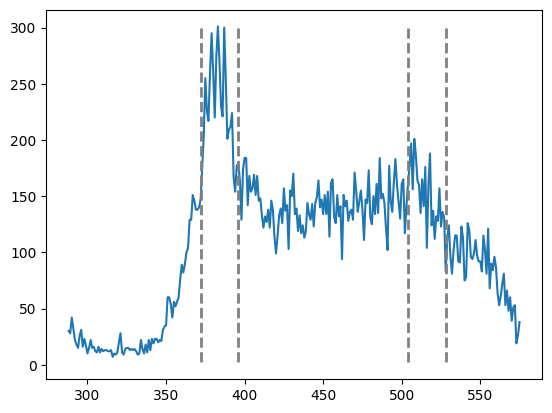

In [10]:
plt.plot(df["ToVol"][ns:ne],label='ToVol')
#plt.plot(df["OccRate"][0:800],label='ToVol')
#plt.plot(df["Speed"][0:800],label='ToVol')
plt.vlines(ns+n7, 2, 300, color='gray', linestyle='--', linewidth=2)
plt.vlines(ns+n9, 2, 300, color='gray', linestyle='--', linewidth=2)
plt.vlines(ns+n18, 2, 300, color='gray', linestyle='--', linewidth=2)
plt.vlines(ns+n20, 2, 300, color='gray', linestyle='--', linewidth=2)

<Axes: xlabel='label', ylabel='count'>

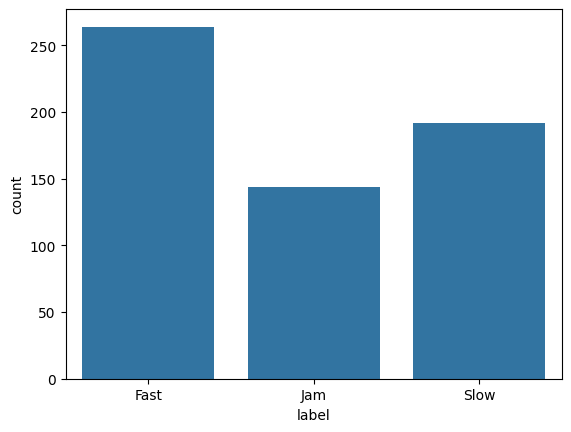

In [11]:
num_classes = 3

def hour_score(hour):
    if ( hour < 7 or hour > 20):
        label = 'Fast'
    elif (hour > 9 and hour < 18) :
        label = 'Slow'
    else :
        label = 'Jam'
    return label

df["label"] = df["hour"].apply(lambda x: hour_score(x))
sns.countplot(x="label", data=df)

<Axes: xlabel='hour', ylabel='ToVol'>

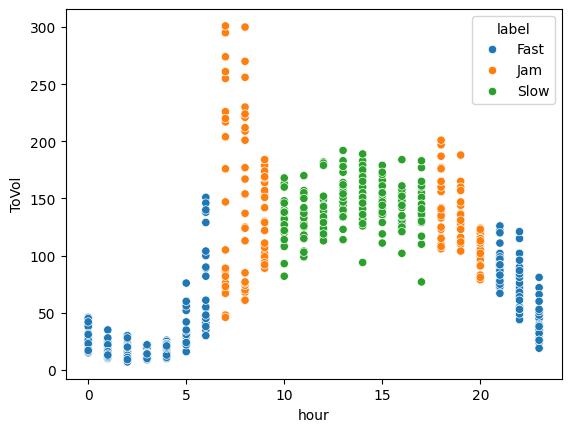

In [12]:
sns.scatterplot(data=df[:576], x = 'hour', y = 'ToVol', hue='label') 

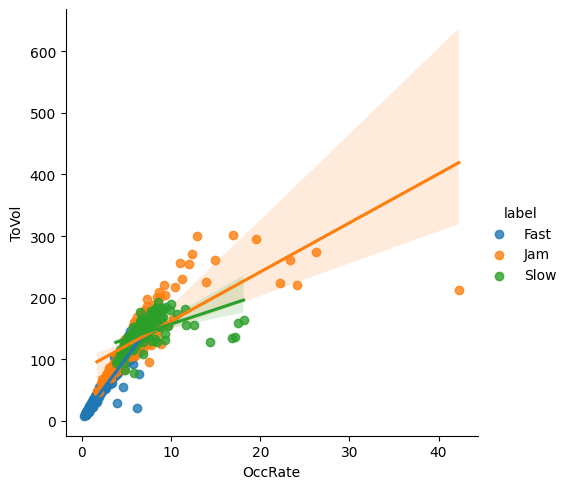

In [13]:
sns.lmplot(x="OccRate", y="ToVol", hue="label", data=df)

In [14]:
df.columns

Index(['Date', 'ToVol', 'SmVol', 'MeVol', 'LaVol', 'Speed', 'OccRate', 'hour',
       'label'],
      dtype='object')

In [15]:
#from sklearn.feature_selection import RFE
#from sklearn.svm import SVC
#X = df.drop(['label','Date','hour'] ,axis="columns")
#y = df['label']
#estimator = SVC(kernel="linear")
#selector = RFE(estimator, n_features_to_select=4, step=1)
#selector = selector.fit(X, y)

In [16]:
#from operator import itemgetter
#features = X.columns.to_list()
#for i, j in (sorted(zip(selector.ranking_ , features), key=itemgetter(0))):
#    print(i,j)

# Classical classifiers 

In [17]:
# classical SVM
X = df[['ToVol', 'MeVol', 'Speed', 'OccRate']]
y = df['label']

In [18]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
X_scaled = StandardScaler().fit_transform(X)
print(X_scaled.shape)
print(X_scaled[:5,:])

(600, 4)
[[-0.88591734 -1.01611495 -0.16641831 -0.72243344]
 [-0.85286072 -0.78383798  0.99354183 -0.73807438]
 [-0.83633241 -0.84190723 -0.12595459 -0.73025391]
 [-0.85286072 -1.01611495 -0.08549086 -0.76935627]
 [-1.15037027 -0.78383798  1.43864282 -0.9257657 ]]


In [19]:
y_enc = LabelEncoder().fit_transform(y)
y_enc[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_enc, test_size=0.20)

## SVM

In [21]:

# Create svm Classifier
ClassifierSVM = SVC()

# Train the model using the training set
ClassifierSVM.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = ClassifierSVM.predict(X_test)

# Model Accuracy: 
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7166666666666667


### SVM performance

In [22]:
# classification report of SVM
expected_y  = y_test
predicted_y = ClassifierSVM.predict(X_test) 

# print classification report and confusion matrix for svm classifier
print("Classification report: \n", metrics.classification_report(expected_y, predicted_y))
print("Confusion matrix: \n", metrics.confusion_matrix(expected_y, predicted_y))

Classification report: 
               precision    recall  f1-score   support

           0       0.88      0.86      0.87        51
           1       0.50      0.25      0.33        32
           2       0.63      0.92      0.75        37

    accuracy                           0.72       120
   macro avg       0.67      0.68      0.65       120
weighted avg       0.70      0.72      0.69       120

Confusion matrix: 
 [[44  5  2]
 [ 6  8 18]
 [ 0  3 34]]


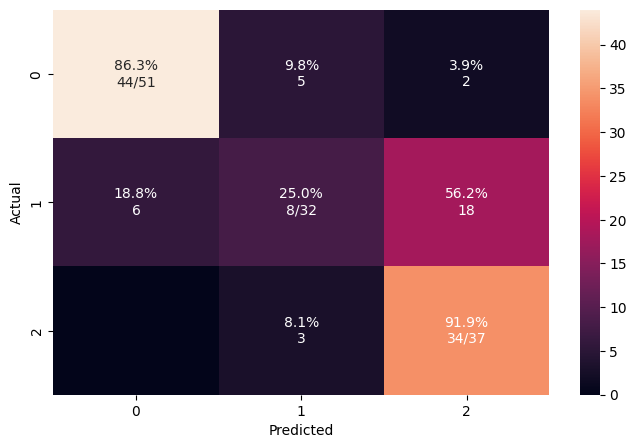

In [23]:
# confusion matrix of SVM
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(5,4)): 
    if ymap is not None: 
        y_pred = [ymap[yi] for yi in y_pred] 
        y_true = [ymap[yi] for yi in y_true] 
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels) 
    cm_sum = np.sum(cm, axis=1, keepdims=True) 
    cm_perc = cm / cm_sum.astype(float) * 100 
    annot = np.empty_like(cm).astype(str) 
    nrows, ncols = cm.shape 
    for i in range(nrows): 
        for j in range(ncols): 
            c = cm[i, j] 
            p = cm_perc[i, j] 
            if i == j: 
                s = cm_sum[i] 
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s) 
            elif c == 0: 
                annot[i, j] = '' 
            else: 
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels) 
    cm.index.name = 'Actual' 
    cm.columns.name = 'Predicted' 
    fig, ax = plt.subplots(figsize=figsize) 
    sns.heatmap(cm, annot=annot, fmt='', ax=ax) 
    
cm_analysis(y_test, predicted_y, labels=None, ymap=None, figsize=(8,5)) 

## ANN

In [24]:
# classical QNN 

model = MLPClassifier(max_iter=1000,  random_state=5)
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))

Final prediction score: [0.78333333]


In [25]:
# classification report of ANN
expected_y  = y_test
predicted_y = model.predict(X_test) 

# print classification report and confusion matrix for the classifier
print("Classification report: \n", metrics.classification_report(expected_y, predicted_y))
print("Confusion matrix: \n", metrics.confusion_matrix(expected_y, predicted_y))

Classification report: 
               precision    recall  f1-score   support

           0       0.92      0.90      0.91        51
           1       0.68      0.53      0.60        32
           2       0.69      0.84      0.76        37

    accuracy                           0.78       120
   macro avg       0.76      0.76      0.75       120
weighted avg       0.78      0.78      0.78       120

Confusion matrix: 
 [[46  3  2]
 [ 3 17 12]
 [ 1  5 31]]


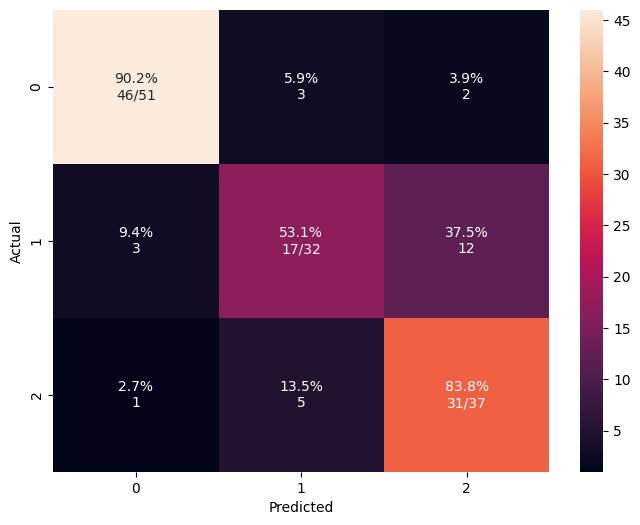

In [26]:
# confusion matrix of ANN
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(5,4)): 
    if ymap is not None: 
        y_pred = [ymap[yi] for yi in y_pred] 
        y_true = [ymap[yi] for yi in y_true] 
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels) 
    cm_sum = np.sum(cm, axis=1, keepdims=True) 
    cm_perc = cm / cm_sum.astype(float) * 100 
    annot = np.empty_like(cm).astype(str) 
    nrows, ncols = cm.shape 
    for i in range(nrows): 
        for j in range(ncols): 
            c = cm[i, j] 
            p = cm_perc[i, j] 
            if i == j: 
                s = cm_sum[i] 
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s) 
            elif c == 0: 
                annot[i, j] = '' 
            else: 
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels) 
    cm.index.name = 'Actual' 
    cm.columns.name = 'Predicted' 
    fig, ax = plt.subplots(figsize=figsize) 
    sns.heatmap(cm, annot=annot, fmt='', ax=ax) 
    
cm_analysis(y_test, predicted_y,labels=None, ymap=None, figsize=(8,6)) 

## Deep Neural Network MLP

In [27]:
print(X_train.shape)
print(num_classes)

(480, 4)
3


In [28]:
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation = 'relu'),
    Dense(32, activation= 'relu'),
    Dense(num_classes, activation= 'softmax')])  

In [29]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer = 'adam', metrics = ['accuracy'])

In [30]:
history = model.fit(X_train,y_train, epochs=50, batch_size=32, validation_split=0.2)
#history = model.fit(X_train, epochs=50)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3726 - loss: 1.0634 - val_accuracy: 0.6458 - val_loss: 0.9918
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6963 - loss: 0.9344 - val_accuracy: 0.7292 - val_loss: 0.8870
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7148 - loss: 0.8341 - val_accuracy: 0.7500 - val_loss: 0.8006
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7327 - loss: 0.7299 - val_accuracy: 0.7396 - val_loss: 0.7337
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6950 - loss: 0.6837 - val_accuracy: 0.7396 - val_loss: 0.6898
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7742 - loss: 0.5912 - val_accuracy: 0.7500 - val_loss: 0.6631
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7848 - loss: 0.5729 - val_accuracy: 0.7708 - val_loss: 0.6405
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7761 - loss: 0.5389 - val_accuracy: 0.7604 - v

In [31]:
model.evaluate(X_test,y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7940 - loss: 0.4736 


[0.5035690069198608, 0.7583333253860474]

In [32]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

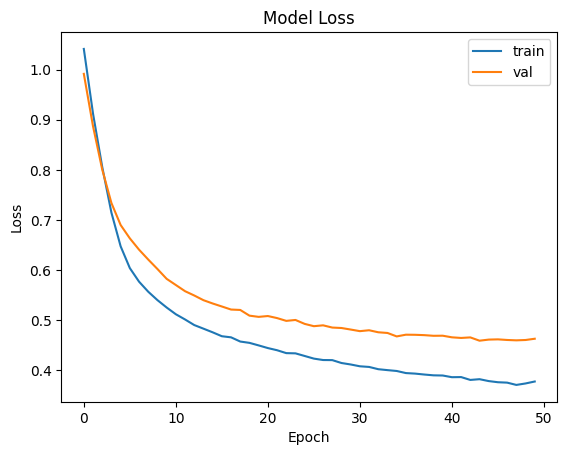

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

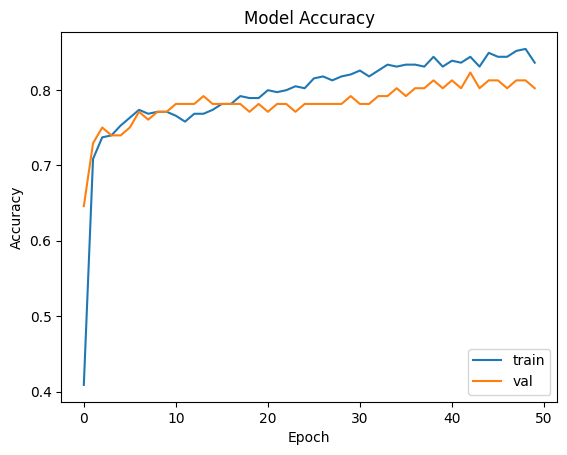

In [34]:
# 훈련 정확도 그래프
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

# Quantum classifiers 

## Simulator를 이용해보자

### 1) QSVC

In [35]:
import time
from qiskit_machine_learning.algorithms import QSVC, VQC
from qiskit.circuit.library import ZZFeatureMap,  RealAmplitudes
# from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit.primitives import StatevectorSampler as Sampler

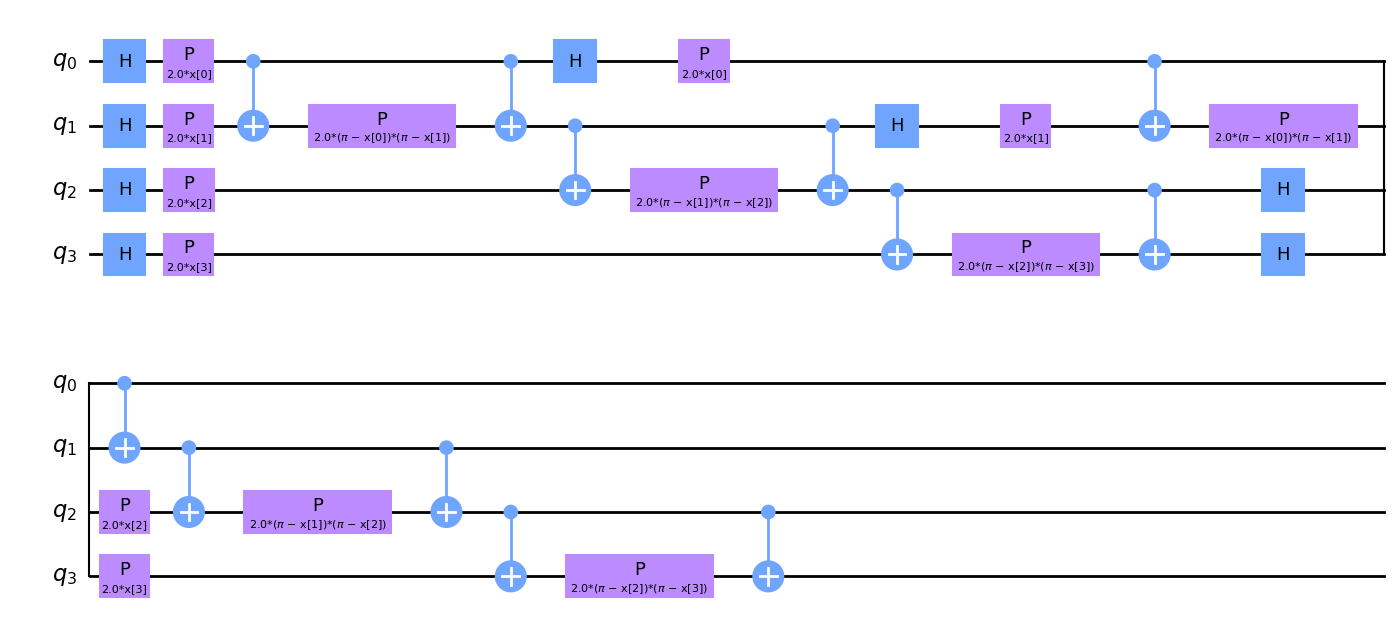

In [37]:
fm_qsvc = ZZFeatureMap(feature_dimension=X_train.shape[1], reps=2, entanglement="linear")
fm_qsvc.decompose().draw(output="mpl", style="clifford", fold=20)

In [38]:
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
qsvc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=fm_qsvc)

In [39]:
qsvc = QSVC(quantum_kernel=qsvc_kernel)

In [40]:
## 600개 데이터일 경우 약 Training time: 1396 seconds
start = time.time()
qsvc.fit(X_train, y_train)
elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

In [41]:
qsvc_score = qsvc.score(X_test, y_test)
print(f"QSVC classification test score: {qsvc_score}")

Training time: 1396 seconds
QSVC classification test score: 0.575


- QSVC performance

In [ ]:
# classification report of QSVC
y_pred = qsvc.predict(X_test) 

In [ ]:
metrics.classification_report(y_test, y_pred)

In [ ]:
metrics.confusion_matrix(y_test, y_pred)

### 2) VQC

feature map
- from classical data to qubit through data encoding, data embedding, data loading
- The most standard fearture is ZZFeatureMap

ansatz

- apply a parameterize quantum circuit.
- objective function characterized the distance between the prediction and known labeled data.
- A parametrized quantum circuit is call a paramenterized trial state, variational form, or ansatz.- 

In [ ]:
feature_map = ZZFeatureMap(feature_dimension = X_train.shape[1], reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

In [ ]:
ansatz = RealAmplitudes(num_qubits = X_train.shape[1], reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

StatevectorSampler를 이용한 Simulator

In [ ]:
sampler = Sampler()

콜백함수에는 
- weights
- objective function values

In [ ]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

Onh-hot encoded format의 경우 crossEntropyLoss를 사용한다.

In [ ]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer = COBYLA(maxiter=50),
    callback=callback_graph,
)

In [ ]:
plt.rcParams["figure.figsize"] = (12, 6)

# clear objective value history
objective_func_vals = []
start = time.time()
vqc.fit(X_train, y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [ ]:
train_score_q4 = vqc.score(X_train, y_train)
test_score_q4 = vqc.score(X_test, y_test)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset    : {test_score_q4:.2f}")

In [ ]:
cost_vqc_train = objective_func_vals

In [ ]:
# 훈련 정확도 그래프
plt.plot(cost_vqc_train)
#plt.plot(history.history['val_accuracy'])
plt.title('Train Process')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['VQC train'])
plt.show()

VQC performance

In [ ]:
# classification report of VQC
expected_y  = y_test
predicted_y = vqc.predict(X_test)

# print classification report and confusion matrix for the classifier
print("Classification report: \n", metrics.classification_report(expected_y, predicted_y))
print("Confusion matrix: \n", metrics.confusion_matrix(expected_y, predicted_y))

In [ ]:
y_test

In [ ]:
predicted_y

In [ ]:
predict = vqc.predict(X_test)
print(f"Predicted labels: {predict}")
print(f"Ground truth:     {y_test}")

## Bagging-QSVC

In [ ]:
# Pipeline Estimator
pipeline = make_pipeline(MinMaxScaler(), qsvc)

# Instantiate the bagging classifier
bgclassifier = BaggingClassifier(base_estimator=pipeline, n_estimators=100, 
                                 random_state=1, n_jobs=-1)

# Fit the bagging classifier
bgclassifier.fit(X_train, y_train)

# Model scores on test and training data
print('Model test Score: %.4f, ' %bgclassifier.score(X_test, y_test),
      'Model training Score: %.4f' %bgclassifier.score(X_train, y_train))

### Bagging-QSVC performace

In [ ]:
# classification report of Bagging-QSVC
expected_y  = y_test
predicted_y = bgclassifier.predict(X_test) 

# print classification report and confusion matrix for the classifier
print("Classification report: \n", metrics.classification_report(expected_y, predicted_y))
print("Confusion matrix: \n", metrics.confusion_matrix(expected_y, predicted_y))

In [ ]:
# confusion matrix of Bagging-QSVC
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(5,4)): 
    if ymap is not None: 
        y_pred = [ymap[yi] for yi in y_pred] 
        y_true = [ymap[yi] for yi in y_true] 
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels) 
    cm_sum = np.sum(cm, axis=1, keepdims=True) 
    cm_perc = cm / cm_sum.astype(float) * 100 
    annot = np.empty_like(cm).astype(str) 
    nrows, ncols = cm.shape 
    for i in range(nrows): 
        for j in range(ncols): 
            c = cm[i, j] 
            p = cm_perc[i, j] 
            if i == j: 
                s = cm_sum[i] 
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s) 
            elif c == 0: 
                annot[i, j] = '' 
            else: 
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels) 
    cm.index.name = 'Actual' 
    cm.columns.name = 'Predicted' 
    fig, ax = plt.subplots(figsize=figsize) 
    sns.heatmap(cm, annot=annot, fmt='', ax=ax) 
    
cm_analysis(y_test, predicted_y, labels=[0,1], ymap=None, figsize=(5,4)) 

In [ ]:
# ROC curve of Bagging-QSVC
from sklearn.metrics import roc_curve
plt.style.use('seaborn')

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    
fper, tper, thresholds = roc_curve(expected_y, predicted_y)
plot_roc_curve(fper, tper)